In [1]:
# Cell 1: imports

import os
from collections import defaultdict
import sys
sys.path.append(os.path.abspath(".."))

import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt



# 字体之类随意，这里不特别设中文
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["image.aspect"] = "auto"
# Cell 2: 导入你自己的 ReadSegments

import sys

# 如果你的项目结构是：
# MultimodalNN/
#   ├─ src/
#   │   └─ ReadSegments.py
#   └─ inspect_mels.ipynb
# 那就把 src 加到 sys.path 里
proj_root = os.path.abspath(".")
src_path = os.path.join(proj_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from src.ReadSegments import ReadSegments, find_segment_paths

# 数据路径配置（改成你真实的 npz 根目录）
SEGMENT_ROOT = "../data/251118"  # 比如 "./data/processed/segments_10s"

# 和训练时保持一致的采样率
TARGET_SR = 16000

# 每个标签想看几个样本
N_PER_LABEL = 4


In [2]:
# Cell 2: 导入你自己的 ReadSegments

import sys

# 如果你的项目结构是：
# MultimodalNN/
#   ├─ src/
#   │   └─ ReadSegments.py
#   └─ inspect_mels.ipynb
# 那就把 src 加到 sys.path 里
proj_root = os.path.abspath(".")
src_path = os.path.join(proj_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from src.ReadSegments import ReadSegments, find_segment_paths

# 数据路径配置（改成你真实的 npz 根目录）
SEGMENT_ROOT = "../data"  # 比如 "./data/processed/segments_10s"

# 和训练时保持一致的采样率
TARGET_SR = 16000

# 每个标签想看几个样本
N_PER_LABEL = 4


In [3]:
# Cell 2: import ReadSegments & AudioResNetEncoder

from src.ReadSegments import ReadSegments, find_segment_paths

# 如果你的模型定义在 train_compare.py
from train_compare import AudioResNetEncoder

# 数据根目录（和训练时一致）
SEGMENT_ROOT = "../data"   # 比如你训练时也是 find_segment_paths("./data")
TARGET_SR = 16000         # 要和训练时传给 ReadSegments / MultiModalLateFusionNet 一致

# 每个标签想看多少个例子
N_PER_LABEL = 4
# Cell 3: 构建 Dataset & 看一下标签分布

all_paths = find_segment_paths(SEGMENT_ROOT)
print("Total npz segments found:", len(all_paths))

dataset = ReadSegments(
    all_paths,
    target_sample_rate=TARGET_SR,
)

print("label2id:", dataset.label2id)

from collections import defaultdict
label_to_indices = defaultdict(list)

for idx in range(len(dataset)):
    sample = dataset[idx]
    lab = sample["norm_label"]  # "0" / "3"
    label_to_indices[lab].append(idx)

for lab, idxs in label_to_indices.items():
    print(f"label={lab}, count={len(idxs)}")


Total npz segments found: 593
Label map (normalized_label -> id):
  id=0: 0
  id=1: 3
label2id: {'0': 0, '3': 1}
label=0, count=357
label=3, count=236


In [4]:
# Cell 4: 实例化 encoder，用来取 melspec 和 dB 变换

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = AudioResNetEncoder(
    sample_rate=TARGET_SR,
    out_dim=128,   # 这个只影响最后 fc，和我们算 mel 没关系
).to(device)

encoder.eval()

# 直接用 encoder.melspec 和 encoder.db，保证和训练时一模一样
def waveform_to_mel_db_with_encoder(wave: torch.Tensor) -> torch.Tensor:
    """
    wave: [T] 或 [1, T]，和训练时 collate_fn 给模型的一样的 1D waveform
    return: [n_mels, T_frames] in dB，完全走 encoder 里的 melspec + db
    """
    if wave.dim() == 1:
        wave = wave.unsqueeze(0)  # [1, T]
    wave = wave.to(device)

    with torch.no_grad():
        mel = encoder.melspec(wave)   # [1, n_mels, T_frames]
        mel_db = encoder.db(mel)      # [1, n_mels, T_frames]

    mel_db = mel_db[0].cpu()          # [n_mels, T_frames]
    return mel_db


In [5]:
# Cell 4: 实例化 encoder，用来取 melspec 和 dB 变换

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = AudioResNetEncoder(
    sample_rate=TARGET_SR,
    out_dim=128,   # 这个只影响最后 fc，和我们算 mel 没关系
).to(device)

encoder.eval()

# 直接用 encoder.melspec 和 encoder.db，保证和训练时一模一样
def waveform_to_mel_db_with_encoder(wave: torch.Tensor) -> torch.Tensor:
    """
    wave: [T] 或 [1, T]，和训练时 collate_fn 给模型的一样的 1D waveform
    return: [n_mels, T_frames] in dB，完全走 encoder 里的 melspec + db
    """
    if wave.dim() == 1:
        wave = wave.unsqueeze(0)  # [1, T]
    wave = wave.to(device)

    with torch.no_grad():
        mel = encoder.melspec(wave)   # [1, n_mels, T_frames]
        mel_db = encoder.db(mel)      # [1, n_mels, T_frames]

    mel_db = mel_db[0].cpu()          # [n_mels, T_frames]
    return mel_db


idx: 0
path: ../data\251026\2025-10-26_18-47-52-SFM3300AW_24410080.edf__record_20251026T111717Z.wav\record_20251026T111717Z.wav__2025-10-26_18-47-52-SFM3300AW_24410080.edf_win00000.npz
audio_id: 
sample_rate: 16000
raw_label: no secretion sound norm_label: 0
wave shape: torch.Size([160000])


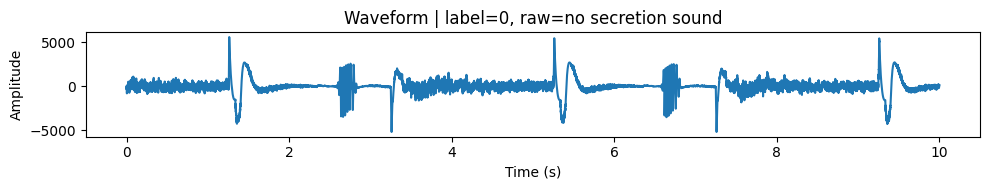

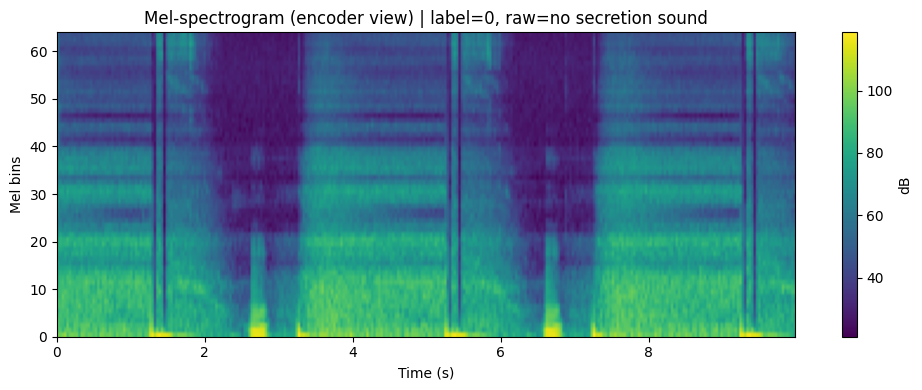

In [6]:
# Cell 5: 看一个具体样本

example_idx = 0  # 随便选一个样本
sample = dataset[example_idx]

wave = sample["audio"].float()          # [T]
sr = sample["sample_rate"]
label_str = sample["norm_label"]
raw_label = sample["raw_label"]
audio_id = sample.get("audio_id", "")
path = sample["path"]

print("idx:", example_idx)
print("path:", path)
print("audio_id:", audio_id)
print("sample_rate:", sr)
print("raw_label:", raw_label, "norm_label:", label_str)
print("wave shape:", wave.shape)

# wave 形状应该和训练时进 model 的一样（除了 collate_fn 里后面加的 padding）

# ① 画 waveform
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 2))
time_axis = torch.arange(wave.shape[0]) / float(sr)
plt.plot(time_axis.numpy(), wave.numpy())
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Waveform | label={label_str}, raw={raw_label}")
plt.tight_layout()
plt.show()

# ② 用 encoder 的 melspec + db 画 Mel
mel_db = waveform_to_mel_db_with_encoder(wave)  # [n_mels, T_frames]

n_mels, t_frames = mel_db.shape
time_axis_mel = torch.arange(t_frames) * encoder.melspec.hop_length / float(sr)

plt.figure(figsize=(10, 4))
plt.imshow(
    mel_db.numpy(),
    origin="lower",
    aspect="auto",
    extent=[time_axis_mel[0].item(), time_axis_mel[-1].item(), 0, n_mels],
)
plt.colorbar(label="dB")
plt.xlabel("Time (s)")
plt.ylabel("Mel bins")
plt.title(f"Mel-spectrogram (encoder view) | label={label_str}, raw={raw_label}")
plt.tight_layout()
plt.show()



=== label = 0 (show 4/357) ===


C:\Users\Wangshuai\AppData\Local\Temp\ipykernel_31360\4120347310.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


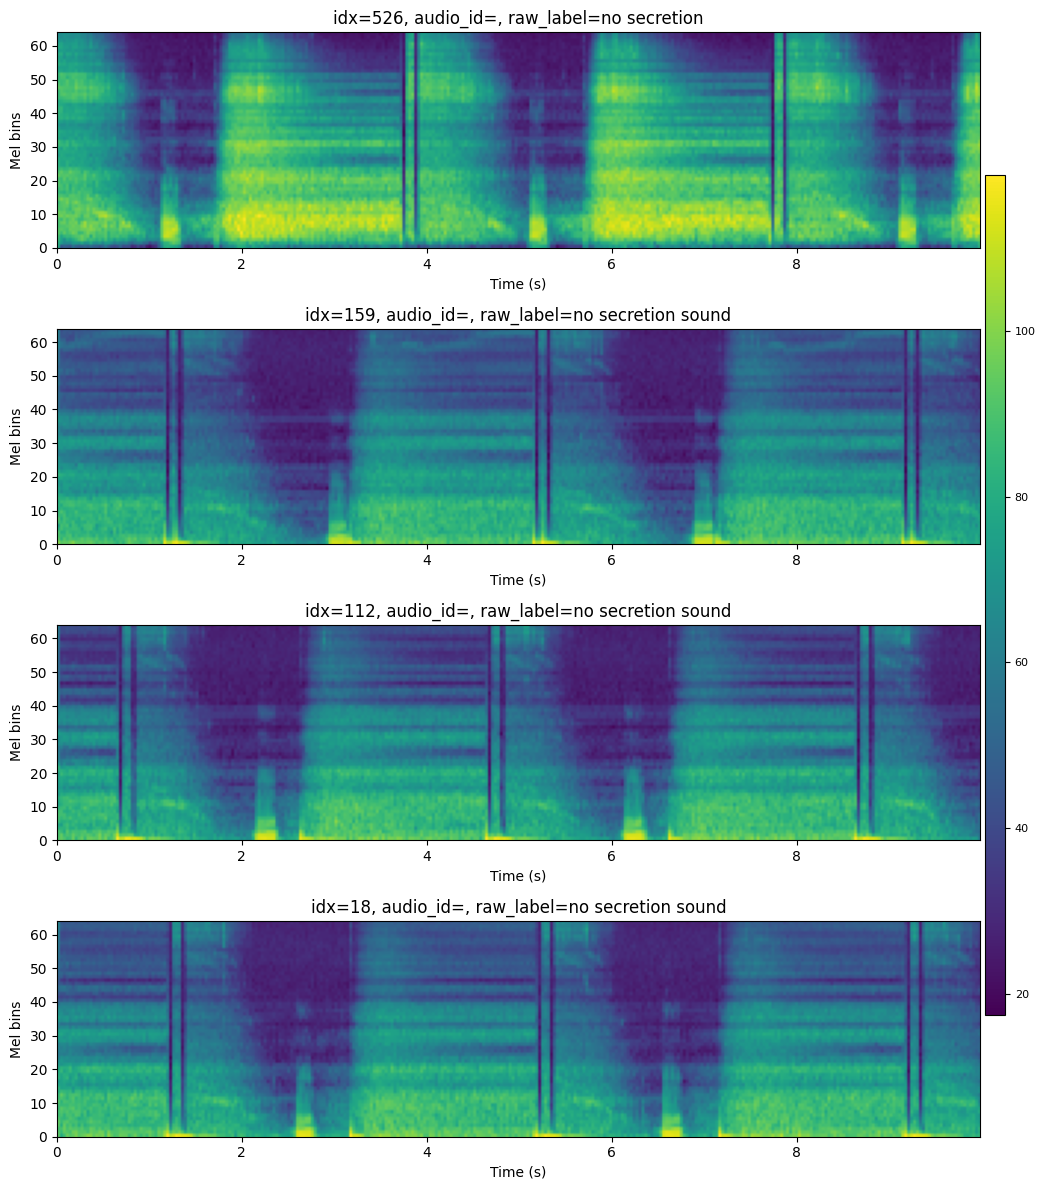


=== label = 3 (show 4/236) ===


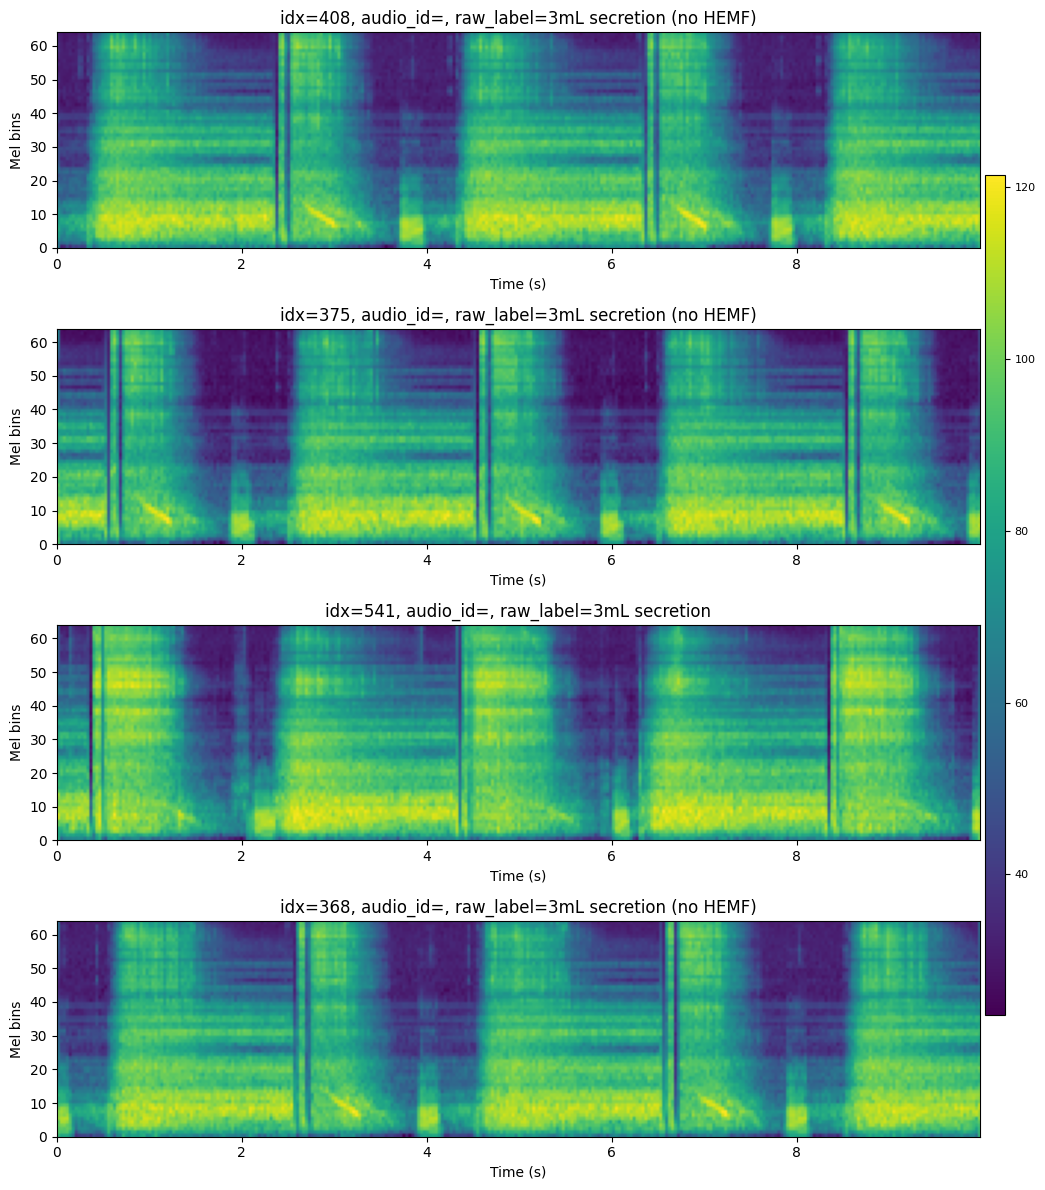

In [7]:
# Cell 6: 每个标签画几个样本的 Mel（grid）
import random
# Cell 6: 每个标签随机画多个样本的 Mel（模型视角）

labels_sorted = sorted(label_to_indices.keys())  # 比如 ["0", "3"]

# 如果你想每次运行都不一样，可以不设种子
# 如果希望“同一次运行里可复现”，可以在这里固定一个 seed
# random.seed(42)  # 可选

for lab in labels_sorted:
    idxs = label_to_indices[lab]
    if not idxs:
        continue

    n_show = min(N_PER_LABEL, len(idxs))
    print(f"\n=== label = {lab} (show {n_show}/{len(idxs)}) ===")

    fig, axes = plt.subplots(n_show, 1, figsize=(10, 3 * n_show))
    if n_show == 1:
        axes = [axes]

    # ⭐ 这里改成随机抽样
    chosen_indices = random.sample(idxs, n_show)

    for ax, idx in zip(axes, chosen_indices):
        sample = dataset[idx]
        wave = sample["audio"].float()
        sr = sample["sample_rate"]
        raw_label = sample["raw_label"]
        audio_id = sample.get("audio_id", "")
        path = sample["path"]

        mel_db = waveform_to_mel_db_with_encoder(wave)
        n_mels, t_frames = mel_db.shape
        time_axis_mel = torch.arange(t_frames) * encoder.melspec.hop_length / float(sr)

        im = ax.imshow(
            mel_db.numpy(),
            origin="lower",
            aspect="auto",
            extent=[time_axis_mel[0].item(), time_axis_mel[-1].item(), 0, n_mels],
        )
        title = f"idx={idx}, audio_id={audio_id}, raw_label={raw_label}"
        ax.set_title(title)
        ax.set_ylabel("Mel bins")
        ax.set_xlabel("Time (s)")



    # create a dedicated axes for the colorbar (left, bottom, width, height in figure coords)
    cax = fig.add_axes([0.99, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax)
    cax.tick_params(labelsize=8)
    
    plt.tight_layout()
    plt.show()
